## Predicting Marketing Churn
### by Megan Petralia

Data taken from Kaggle

https://www.kaggle.com/datasets/arashnic/marketing-series-customer-churn

In [18]:
# Load necessary packages
#Call packages to be used below
import warnings; warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
from bayes_opt import BayesianOptimization
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Importing more required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
import warnings

#makes numby printouts easier to read
np.set_printoptions(precision=3, suppress=True)

In [15]:
train = pd.read_csv("train.csv" , header=0 )
test = pd.read_csv("test.csv" , header=0 )
train.head()

,CustomerID,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,7590-VHVEG,0,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,1,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,1,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,1,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,0,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [23]:
print('Class distribution in training data')
pd.Categorical(train['Churn']).describe()

Class distribution in training data


,counts,freqs
categories,,
No,4784,0.736113
Yes,1715,0.263887


Note there are significantly more 'No' than 'Yes' . Will likely need to fix class impalance below.

Set up 80/20 Training Validation split and X, Y vectors for model

In [24]:
#split dataset for modeling
training = train.sample(frac=0.8, random_state=0)
validation = train.drop(training.index)

In [25]:
(x_train, y_train) = ( training[training.columns[0:20]] , training['Churn'] ) 
(x_test, y_test) = ( validation[validation.columns[0:20]] , validation['Churn'] ) 

Checking for class imbalance

Yes :  3797
No :  1402


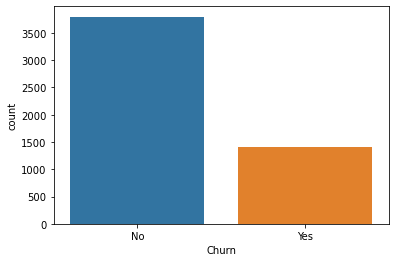

In [27]:
ax = sns.countplot(y_train,label="Count") 
No, Yes = y_train.value_counts()
print('Yes : ', No)
print('No : ', Yes)

Iin the training dataset, there are almost double the amount of profiles without churn than with. Rebalancing the dataset is needed.

To rebalance, a smaller sample of the 'No' will be taken.

In [30]:
#Also taking a smaller sample than what's available for faster computing below
Nos = training[training.Churn == 'No'].sample(1400)
Yess = training[training.Churn == 'Yes'].sample(1400)
training_balanced = Nos.append(Yess)

In [35]:
(x_train, y_train) = ( training[training_balanced.columns[0:20]] , training_balanced['Churn'] ) 

In [32]:
# Feature names as a list
col = x_train.columns # .columns gives columns names in data 
print(col)

Index(['CustomerID', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges'],
      dtype='object')


Drop unnecessary columns

In [36]:
x_train = x_train.drop('CustomerID' , axis = 1)
x_train.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
1828,1,0,No,No,42,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Electronic check,25.05,949.85
2425,1,0,No,No,26,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,20.30,511.25
3522,1,0,Yes,Yes,37,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),19.80,677.05
5380,1,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,80.25,144.55
4910,0,0,No,No,30,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,One year,No,Bank transfer (automatic),85.35,2530.40


In [38]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5199 entries, 1828 to 542
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             5199 non-null   int64  
 1   Senior Citizen     5199 non-null   int64  
 2   Partner            5199 non-null   object 
 3   Dependents         5199 non-null   object 
 4   Tenure             5199 non-null   int64  
 5   Phone Service      5199 non-null   object 
 6   Multiple Lines     5199 non-null   object 
 7   Internet Service   5199 non-null   object 
 8   Online Security    5199 non-null   object 
 9   Online Backup      5199 non-null   object 
 10  Device Protection  5199 non-null   object 
 11  Tech Support       5199 non-null   object 
 12  Streaming TV       5199 non-null   object 
 13  Streaming Movies   5199 non-null   object 
 14  Contract           5199 non-null   object 
 15  Paperless Billing  5199 non-null   object 
 16  Payment Method     519

In [39]:
categorical_vars = ['Partner' , 'Dependents', 'Phone Service' , 
    'Multiple Lines', 'Internet Service' , 'Online Security' , 
    'Online Backup' , 'Device Protection' , 'Tech Support' , 'Streaming TV',
    'Streaming Movies', 'Contract' , 'Paperless Billing' , 'Payment Method']

In [41]:
x_train_categorical = x_train[categorical_vars]
for col in x_train_categorical.columns:
    print(x_train_categorical[col].value_counts())

No     2709
Yes    2490
Name: Partner, dtype: int64
No     3677
Yes    1522
Name: Dependents, dtype: int64
Yes    4706
No      493
Name: Phone Service, dtype: int64
No                  2515
Yes                 2191
No phone service     493
Name: Multiple Lines, dtype: int64
Fiber optic    2299
DSL            1771
No             1129
Name: Internet Service, dtype: int64
No                     2600
Yes                    1470
No internet service    1129
Name: Online Security, dtype: int64
No                     2310
Yes                    1760
No internet service    1129
Name: Online Backup, dtype: int64
No                     2302
Yes                    1768
No internet service    1129
Name: Device Protection, dtype: int64
No                     2573
Yes                    1497
No internet service    1129
Name: Tech Support, dtype: int64
No                     2066
Yes                    2004
No internet service    1129
Name: Streaming TV, dtype: int64
No                     2039
Yes   

In [ ]:
x_numeric = x_train.replace({"Partner":      {"Yes": 1, "No": 0},
            "Dependents": {"Yes": 1, "No": 0},
           
            })
x_numeric.head()

REST OF CODE TBD